# Predicting crops based on the soil metrics

![img/farmer_in_a_field.jpg](img/farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  


**Disclaimer**: This project was completed originally as part of the Data Camp's Data Science Professional track. Ever since it's been improved by exploring features distribution, selection, alternative machine learning models to Logistic Regression (such as Random Forest and Neural Network), performing cross-validation to tune the hyperparameters of the models and providing an interpretation of the results

### 1. Data Collection and Exploration

- Exploring the dataset to understand its structure, check for missing values.
- Visualizing the distribution of each soil metric (N, P, K, pH) across different crop types.

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import f1_score

# Load the dataset
crops = pd.read_csv("dataset/soil_measures.csv")

In [2]:
crops.head() #visualizing the first 5 rows

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [3]:
crops.shape

(2200, 5)

In [4]:
crops.isnull().sum() #checking for missing values

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

In [5]:
crops.dtypes #checking the data type of each column

N         int64
P         int64
K         int64
ph      float64
crop     object
dtype: object

In [6]:
crops['crop'].value_counts()

crop
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

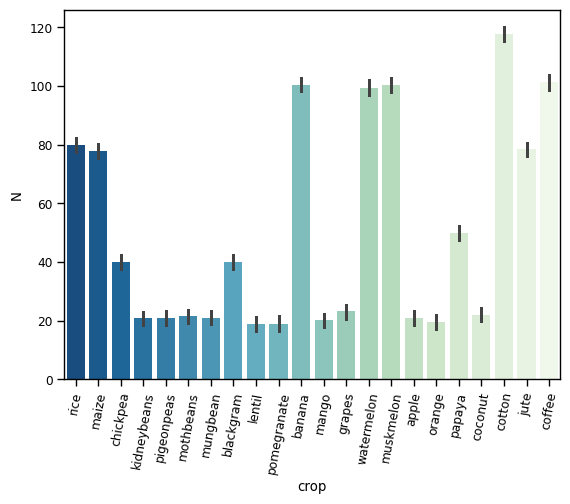

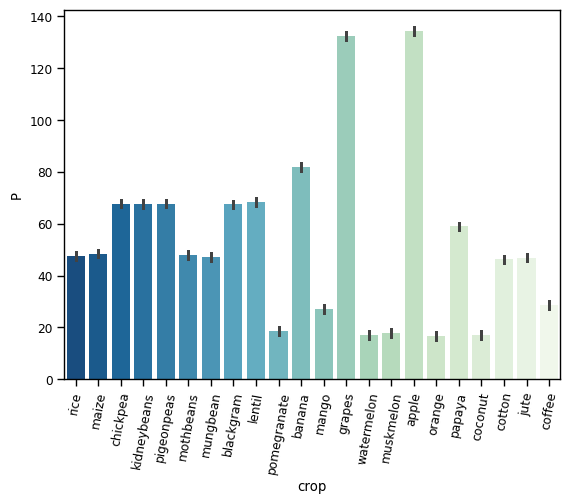

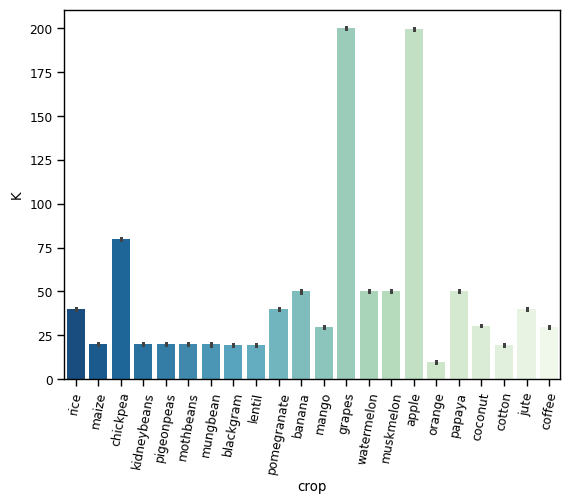

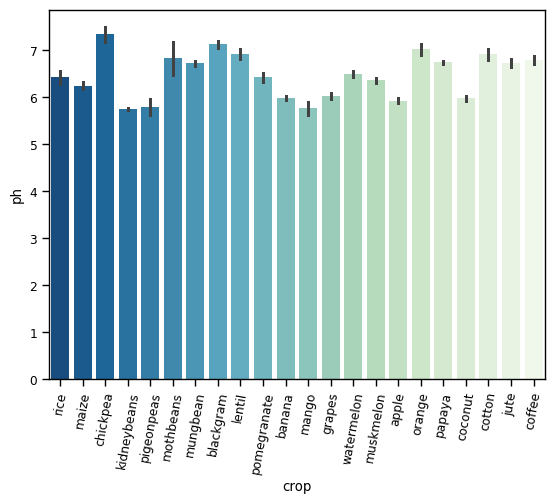

In [57]:
# Visualizing the distribution of each soil metric (N, P, K, pH) across different crop types.

cols=crops.columns.to_list()[:-1]

def plot_crops_soil(col):
    sns.barplot(y= col, x = "crop", data = crops, palette=("GnBu_r"))
    plt.xticks(rotation=80)
    sns.set_context('paper')
    plt.show()

for col in cols:
    plot_crops_soil(col)

observation

### 2. Data Processing (Train, Test split)

In [58]:
X=crops.drop('crop', axis=1)
y=crops[['crop']]
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=22)

### 3. Feature Selection and Engineering

Assessing the importance of each soil metric in predicting crop types:

- *Feature importance based on mean decrease in impurity* : feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.  This is not recommended for high cardinality features
        
- *Feature importance based on feature permutation*: permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

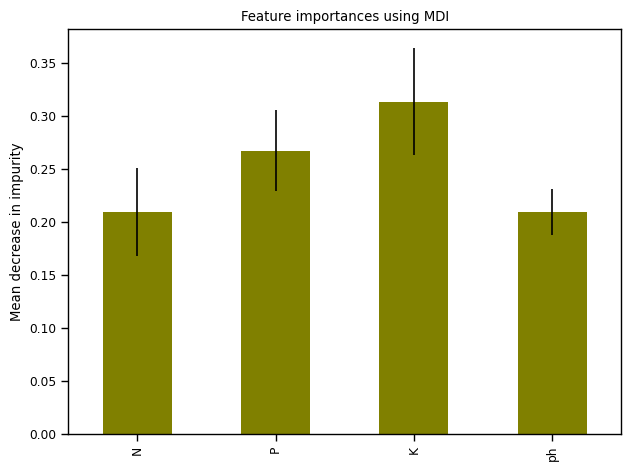

In [75]:
# Assess feature importance using Random Forest
forest=RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, color='olive')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


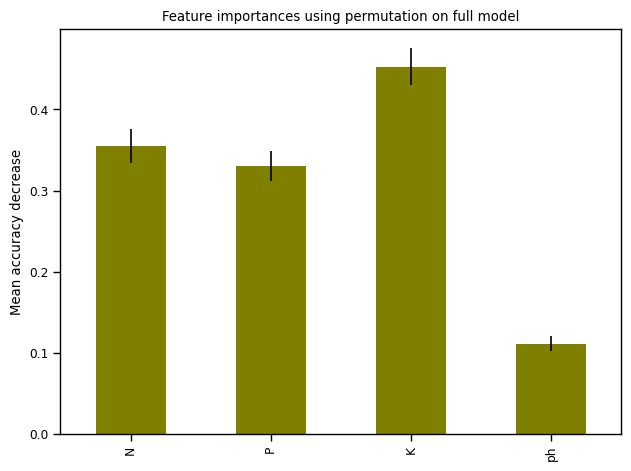

In [74]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color='olive')
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Observations:

### 4. Addressing Multicollinearity

In [76]:
X_train.corr()

,N,P,K,ph
N,1.000000,-0.237410,-0.144130,0.088276
P,-0.237410,1.000000,0.736475,-0.139021
K,-0.144130,0.736475,1.000000,-0.169690
ph,0.088276,-0.139021,-0.169690,1.000000


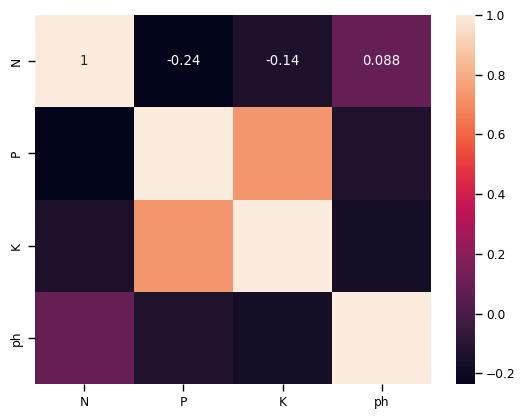

In [77]:
sns.heatmap(X_train.corr(), annot=True)
plt.show()

Observations

In [78]:
final_features=['N','K','ph']


### 5. Model Selection and Training:
- Exploring Logistic Regression, Random Forest, Support Vector Machine, and Neural Network
- Training the model using the training data.
- Tuning hyperparameters using cross-validation.

#### a. Logistic Regression

In [79]:
# fitting a multiclass model
log_reg=LogisticRegression(max_iter=2000, multi_class='multinomial')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
model_performance = f1_score(y_test, y_pred, average='weighted')
model_performance

0.6464621404910126

#### b. Random Forest

In [83]:
rf_model=RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
f1_score(y_test, y_pred_rf, average='weighted')

0.7460208196236069

#### d. Neural network

In [110]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

num_classes = y_train.nunique()
#y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded.values, num_classes=num_classes)

tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]), 
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

tf_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
tf_model.fit(X_train, y_train_encoded, epochs=100)


Epoch 1/100
55/55 [==============================] - 0s 939us/step - loss: 14.1731 - accuracy: 0.0705
Epoch 2/100
55/55 [==============================] - 0s 849us/step - loss: 3.3824 - accuracy: 0.1750
Epoch 3/100
55/55 [==============================] - 0s 855us/step - loss: 1.8113 - accuracy: 0.3358
Epoch 4/100
55/55 [==============================] - 0s 821us/step - loss: 1.4543 - accuracy: 0.4432
Epoch 5/100
55/55 [==============================] - 0s 843us/step - loss: 1.3377 - accuracy: 0.4750
Epoch 6/100
55/55 [==============================] - 0s 846us/step - loss: 1.2377 - accuracy: 0.4989
Epoch 7/100
55/55 [==============================] - 0s 845us/step - loss: 1.1664 - accuracy: 0.5210
Epoch 8/100
55/55 [==============================] - 0s 847us/step - loss: 1.1480 - accuracy: 0.5369
Epoch 9/100
55/55 [==============================] - 0s 858us/step - loss: 1.0829 - accuracy: 0.5562
Epoch 10/100
55/55 [==============================] - 0s 843us/step - loss: 1.0193 - accur

### 6.Model Evaluation:
Evaluating the models performance using metrics like accuracy, precision, recall, and F1-score.
Using confusion matrices to understand classification errors.

### 7. Interpretability:
Understanding which soil metrics contribute most to predicting specific crop types by visualizing feature importances.